# Part-of-speech Tagger con Keras

In [1]:
import keras
from keras.preprocessing import text

import numpy as np
import pickle
import pandas as pd

from collections import Counter

Using TensorFlow backend.


In [118]:
import string
def removeLower(tag):
    t = tag.translate(None,string.ascii_lowercase)
    t = t.translate(None,string.digits)
    return t

In [60]:
# Apriamo il file del postagger con pandas
data = pd.read_table("PoSTaggingCorpus/train", sep="\s*")
#visualizziamo il risultato
#print textfile.words
#texfile.tags
words = list(set(data.words))
words.append("<PADDING>")
n_words = len(words)
tags = list(set([removeLower(t) for t in data.tags]))
tags.append("<P>")
n_tags = len(tags)

print "#words:",n_words,"#tags:",n_tags

print words[-1],tags[-1]
#print sorted(tags)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


#words: 17315 #tags: 39
<PADDING> <P>


In [61]:
txt = open("PoSTaggingCorpus/train","r")
txt.readline()
txt.readline()
line = txt.readline()
sentences = []
sn = []
while line:
    if line == "\n":
       # print "LINEEND",sn
        sentences.append(sn)
        sn = []
        line = txt.readline()
    else: 
        #print "word"
        ln = line.split("\t")
        ln[1] = ln[1].strip("\n")
        sn.append((ln[0],removeLower(ln[1])))
        line = txt.readline()

print "#sentecses:",len(sentences) 
print sentences[0]

#sentecses: 3719
[('\xc3\x88', 'V'), ('abbastanza', 'B'), ('strano', 'A'), ('il', 'RD'), ('disinteresse', 'S'), ('con', 'E'), ('cui', 'PR'), ('\xc3\xa8', 'VA'), ('stata', 'VA'), ('accolta', 'V'), ("l'", 'RD'), ('intervista', 'S'), ('che', 'PR'), ("l'", 'RD'), ('on.', 'SA'), ('Rino', 'SP'), ('Formica', 'SP'), ('ha', 'VA'), ('dato', 'V'), ('sabato', 'S'), ('scorso', 'A'), ('alla', 'EA'), ('Repubblica', 'SP'), ('.', 'FS')]


In [62]:
#longest sentence?
print max([len(s) for s in sentences])


175


In [63]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
print word2idx["<PADDING>"]

tag2idx = {t: i for i, t in enumerate(tags)}
print tag2idx["<P>"]

17315
38


In [79]:
max_len = 175
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["<PADDING>"])
# X is the value for the residual class
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["<P>"])


In [80]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [81]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.05)
X_te.shape

(186, 175)

In [82]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [68]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
history = None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 175)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 175, 20)           346320    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 175, 100)          28400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 175, 50)           5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 175, 39)           3588      
Total params: 383,358
Trainable params: 383,358
Non-trainable params: 0
_________________________________________________________________


In [69]:
History = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Train on 3179 samples, validate on 354 samples
Epoch 1/5
3179/3179 [==============================] - 63s - loss: 0.7764 - viterbi_acc: 0.8085 - val_loss: 0.4606 - val_viterbi_acc: 0.8645
Epoch 2/5
3179/3179 [==============================] - 66s - loss: 0.4209 - viterbi_acc: 0.8780 - val_loss: 0.3601 - val_viterbi_acc: 0.8978
Epoch 3/5
3179/3179 [==============================] - 65s - loss: 0.2907 - viterbi_acc: 0.9112 - val_loss: 0.2348 - val_viterbi_acc: 0.9285
Epoch 4/5
3179/3179 [==============================] - 67s - loss: 0.1901 - viterbi_acc: 0.9419 - val_loss: 0.1578 - val_viterbi_acc: 0.9527
Epoch 5/5
3179/3179 [==============================] - 65s - loss: 0.1297 - viterbi_acc: 0.9616 - val_loss: 0.1193 - val_viterbi_acc: 0.9638


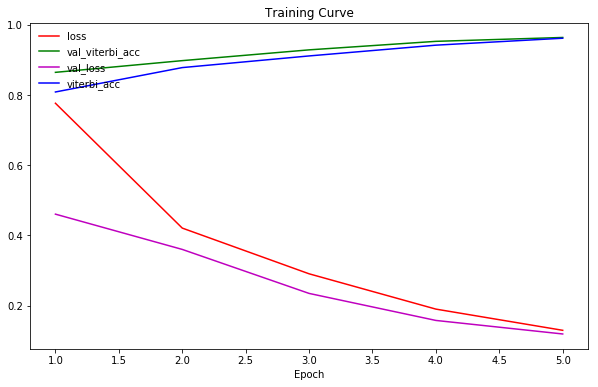

In [70]:
from matplotlib import pyplot as plt

def plot_traincurve(history):
    # define 4 colors for up to 4 different values in history
    colors = {'loss':'r', 'viterbi_acc':'b', 'val_loss':'m', 'val_viterbi_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")


    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)
    
plot_traincurve(history)


In [114]:
def acc_score(pred, test):
    r = 0.0
    c = 0.0
    for i,p in enumerate(pred):
        if test[i] == tag2idx["<P>"]:
            break
        else:
            r += 1
            if p == test[i]:
                c += 1.0
            
    #print c,"out of",r
    return c / r 

In [112]:
def testSentence(i, verbose=False):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)

    if verbose:
        #print p,true
        print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
        print(30 * "=")
        for w, t, pred in zip(X_te[i], true, p[0]):
            if w != word2idx["<PADDING>"]:
                print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
    
    return acc_score(p[0],true)

testSentence(4, True)

29.0 out of 35.0


0.8285714285714286

In [117]:
res = []
for i,_ in enumerate(X_te):
    print i,"\r",
    res.append(testSentence(i))
#print res
print np.mean(res)

0.805085914497
